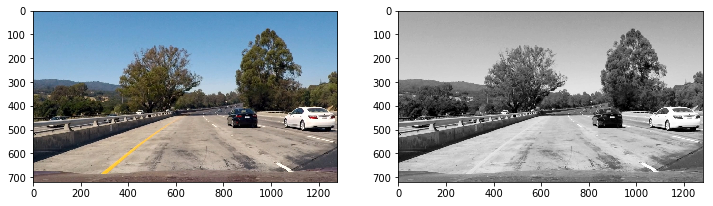

In [8]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

image = mpimg.imread("test_images/test1.jpg")
#image = mpimg.imread("./training-data/vehicles/GTI_Right/image0110.png")
grey_image = rgb2gray(image)
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(grey_image, cmap='Greys_r')

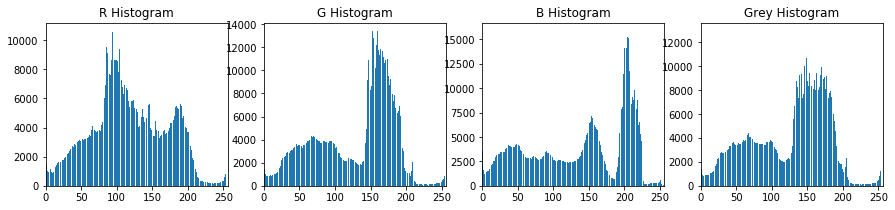

In [9]:
import numpy as np
def show_histogram(image):
    rhist = np.histogram(image[:,:,0], bins=256, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=256, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=256, range=(0, 256))
    greyhist = np.histogram(rgb2gray(image), bins=256, range=(0, 256))
    
    bin_centers = rhist[1][:-1]
    
    fig = plt.figure(figsize=(15,3))
    plt.subplot(141)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(142)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(143)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    plt.subplot(144)
    plt.bar(bin_centers, greyhist[0])
    plt.xlim(0, 256)
    plt.title('Grey Histogram')
    plt.show()
    return

show_histogram(image)

In [10]:
#Compute spatial features
def bin_spatial(img, size=(32, 32)):
    rcolor = cv2.resize(img[:,:,0], size).ravel()
    gcolor = cv2.resize(img[:,:,1], size).ravel()
    bcolor = cv2.resize(img[:,:,2], size).ravel()
    return np.concatenate((rcolor, gcolor, bcolor))
print("spatial feature numbers:",bin_spatial(image).shape[0])

spatial feature numbers: 3072


In [11]:
#Compute color histogram features
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
def color_hist_old(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    hist_features = channel1_hist[0]
    return np.array(hist_features)
print("color histogram feature numbers:",color_hist(image).shape[0])

color histogram feature numbers: 96


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


hog histogram feature numbers: 324612


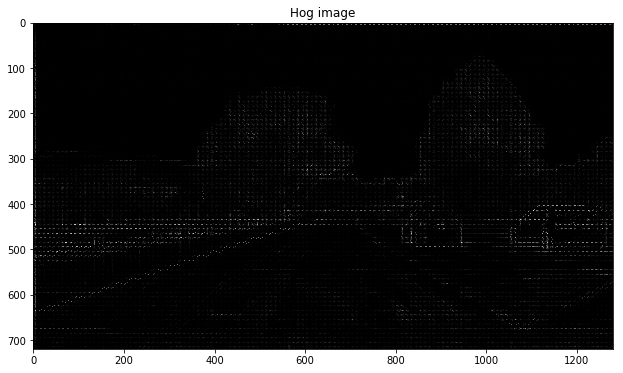

In [12]:
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
features,hog_image = get_hog_features(grey_image,9,10,2,vis=True)
print("hog histogram feature numbers:",features.shape[0])
fig = plt.figure(figsize=(12,6))
plt.imshow(hog_image, cmap='Greys_r')
plt.title('Hog image')
plt.show()

In [13]:
def extract_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: image = np.copy(image)
        
    if spatial_feat == True:
        spatial_features = bin_spatial(image, size=spatial_size)
        features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(image, nbins=hist_bins)
        features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(image.shape[2]):
                hog_features.append(get_hog_features(image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features) 
        else:
            hog_features = get_hog_features(image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
    
    features = np.concatenate(features,axis=0)
    return features

print("total feature numbers:",extract_features(image,color_space='YUV',hog_channel="ALL").shape[0])

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


total feature numbers: 1531476


In [14]:
# Get image file names
import glob
images = glob.glob(r'./training-data/*/*/*.png')
cars = []
notcars = []
all_cars = []
all_notcars = []

for image in images:
    if 'non-vehicles' in image:
        all_notcars.append(image)
    else:
        all_cars.append(image)

print ("not car numbers:",len(all_notcars))
print ("with car numbers:",len(all_cars))
        

not car numbers: 8968
with car numbers: 2258


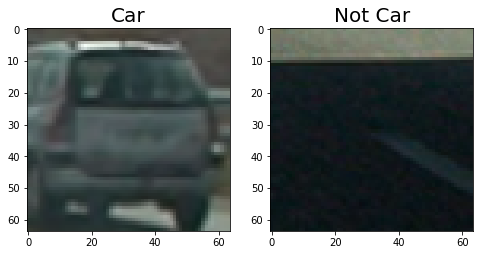

In [15]:
# Get only 1/5 of the training data to avoid overfitting
for ix, notcar in enumerate(all_notcars):
    if ix % 4 == 0:
        notcars.append(notcar)
        
for ix, car in enumerate(all_cars):
    if ix % 1 == 0:
        cars.append(car)
        
car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])

def compare_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    fig = plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.imshow(image1)
    plt.title(image1_exp, fontsize=20)
    plt.subplot(122)
    plt.imshow(image2)
    plt.title(image2_exp, fontsize=20)
    plt.show()
        
compare_images(car_image, notcar_image, "Car", "Not Car")

In [16]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [17]:
cars_features = []
notcars_features = []
for car in cars:
    car = mpimg.imread(car)
    car_features = extract_features(car, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    cars_features.append(car_features)
    
for notcar in notcars:
    notcar = mpimg.imread(notcar)
    notcar_features = extract_features(notcar, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcars_features.append(notcar_features)

print ("cars images number:",len(cars_features))
print ("cars features number:",len(cars_features[0]))
print ("notcars images number:",len(notcars_features))
print ("notcars features number:",len(notcars_features[0]))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


cars images number: 2258
cars features number: 3036
notcars images number: 2242
notcars features number: 3036


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time
X = np.vstack((cars_features,notcars_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(cars_features)), np.zeros(len(notcars_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3036
4.29 Seconds to train SVC...
Test Accuracy of SVC =  0.97


In [19]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
image = mpimg.imread("test_images/test1.jpg")
windows = slide_window(image,x_start_stop=[600, None], y_start_stop=[350, 550],xy_window=(120, 120), xy_overlap=(0.8, 0.8))
print (len(windows))

100


In [20]:
def search_windows(img, windows, clf, scaler,
                    color_space = 'RGB',
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img,color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = mpimg.imread("test_images/test1.jpg")
on_windows_list = search_windows(image,windows,svc,X_scaler,
                                 color_space = color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 hist_range=(0, 256), orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)
print (len(on_windows_list))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


12


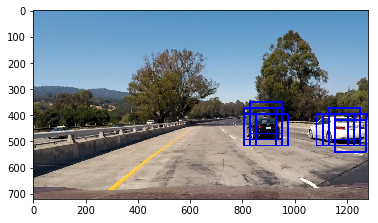

In [21]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
result_image = draw_boxes(image,on_windows_list)
fig = plt.figure()
plt.imshow(result_image)
plt.show()

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


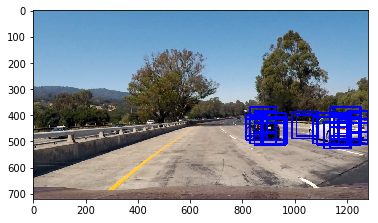

In [22]:
def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    all_windows_list = []
    
    #one size
    windows = slide_window(image,x_start_stop=[750, None], y_start_stop=[370, 530],xy_window=(120, 120),xy_overlap=(0.6, 0.8))
    on_windows_list = search_windows(image,windows,svc,X_scaler,
                                 color_space = color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 hist_range=(0, 256), orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    all_windows_list+=on_windows_list
    
    #one size
    windows = slide_window(image,x_start_stop=[750, None], y_start_stop=[370, 530],xy_window=(100, 100),xy_overlap=(0.6, 0.8))
    on_windows_list = search_windows(image,windows,svc,X_scaler,
                                 color_space = color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 hist_range=(0, 256), orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    all_windows_list+=on_windows_list
     
    #one size
    windows = slide_window(image,x_start_stop=[750, None], y_start_stop=[370, 530],xy_window=(80, 80),xy_overlap=(0.6, 0.8))
    on_windows_list = search_windows(image,windows,svc,X_scaler,
                                 color_space = color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 hist_range=(0, 256), orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    all_windows_list+=on_windows_list
      
    result_image = draw_boxes(image,all_windows_list)
    
    return all_windows_list,result_image

all_windows_list,result_image = apply_sliding_window(image,svc,X_scaler, pix_per_cell=pix_per_cell,
                     cell_per_block=cell_per_block, spatial_size=spatial_size,
                    hist_bins=hist_bins)
fig = plt.figure()
plt.imshow(result_image)


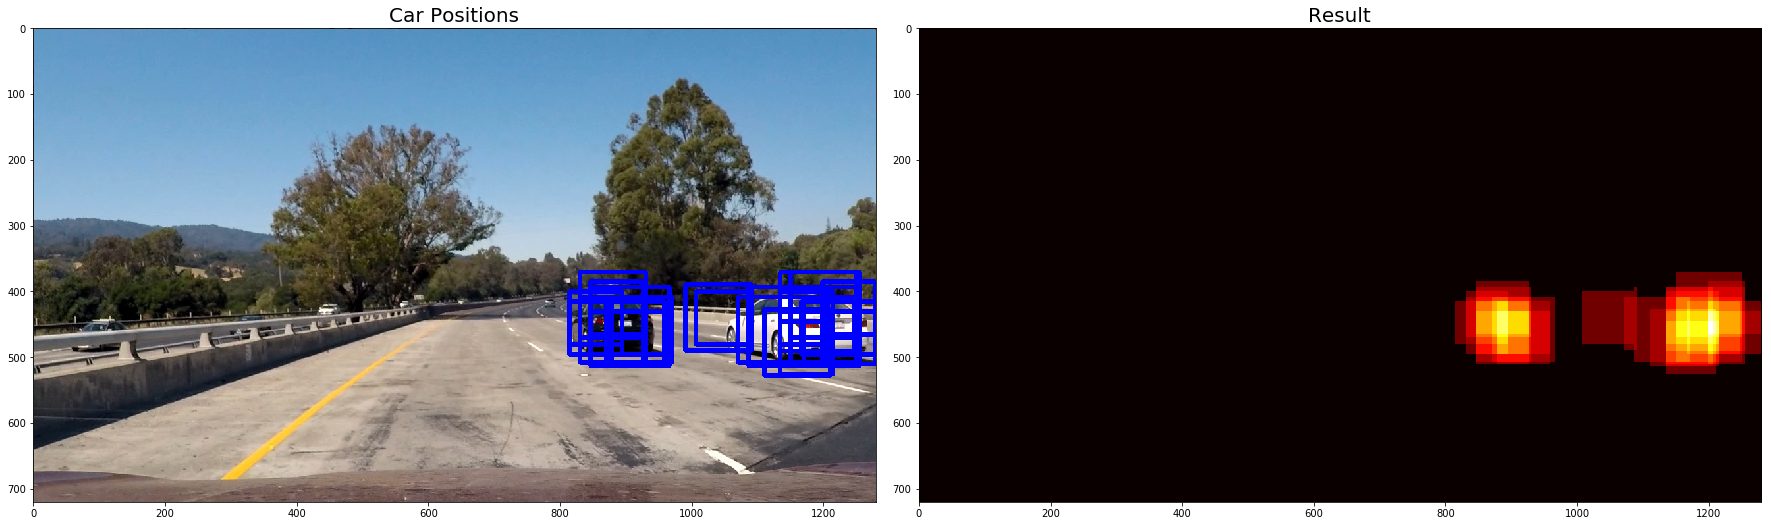

In [23]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if 1.5*(np.max(nonzerox)-np.min(nonzerox))<(np.max(nonzeroy)-np.min(nonzeroy)):continue
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(result_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, all_windows_list)
    
# Apply threshold to help remove false positives
threshold = 1
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

def show_images(image1, image2,  image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2, cmap='hot')
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
show_images(result_image, heatmap, "Car Positions", "Result")

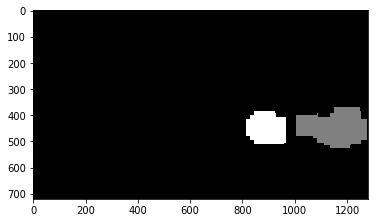

In [24]:
plt.imshow(labels[0], cmap='gray')

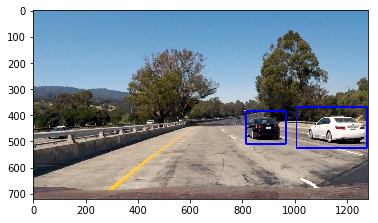

In [25]:
plt.imshow(draw_img)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


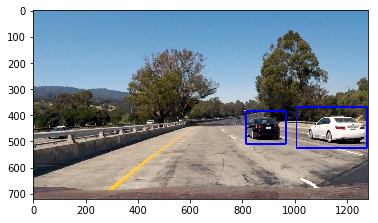

In [26]:
def find_cars(image):
    all_windows_list,result_image = apply_sliding_window(image,svc,X_scaler, pix_per_cell=pix_per_cell,
                     cell_per_block=cell_per_block, spatial_size=spatial_size,
                    hist_bins=hist_bins)
    
    heat = np.zeros_like(result_image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, all_windows_list)  
    # Apply threshold to help remove false positives
    threshold = 1
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

img = find_cars(image)
plt.imshow(img)

In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(find_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  3.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

CPU times: user 12.1 s, sys: 254 ms, total: 12.4 s
Wall time: 13.1 s


In [28]:
HTML("""
<video width="800" height="500" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [29]:
output = 'project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


100%|█████████▉| 1260/1261 [07:06<00:00,  3.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

CPU times: user 6min 55s, sys: 8.72 s, total: 7min 4s
Wall time: 7min 7s


In [30]:
HTML("""
<video width="800" height="500" controls>
  <source src="{0}">
</video>
""".format(output))